# k-means Clustering

This Python notebook analyses a credit card dataset describing individuals credit card usage behaviour using 18 columns. The online dataset can be found on Kaggle here: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata

The dataset columns are described below:

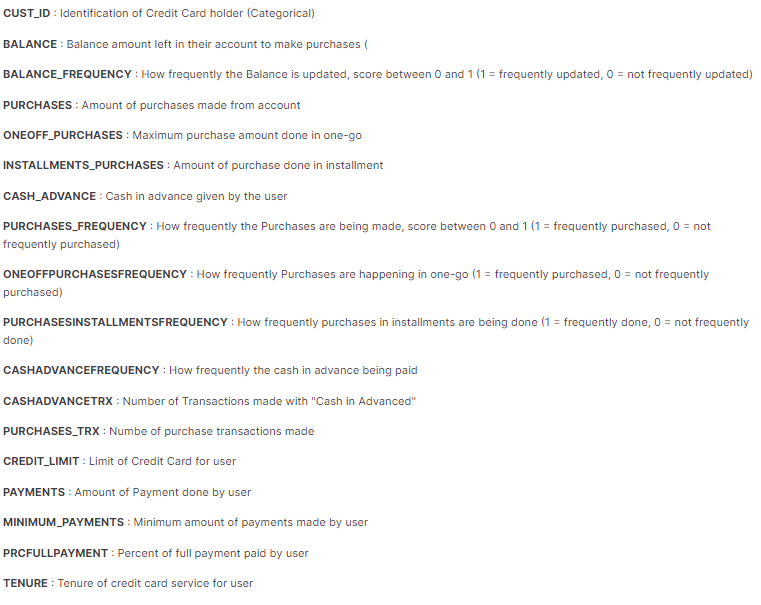

The objective of this script is to conduct customer segmentation in order to define a marketing strategy. Each individual will be categorised into classes formed through iteratively calculating distance between each data point and a cluster centroid and recategorising all data points. The number of clusters to categorise the data to is defined by model hyperparameter, k. k-means clustering is a type of unsupervised learning. 

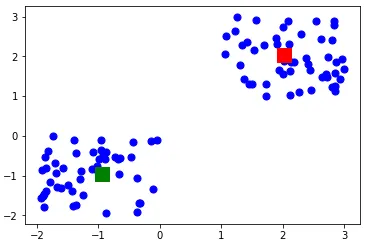

The model works by assigning datapoints to a cluster based on the minimum distance between point to centroid using the Euclidean distance metric as per below:
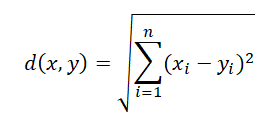

Each centroid is re-initialised through calculating the average of all data points within the cluster – shown below. All data points are then re-mapped onto the new centroid locations. This process is repeated until all data points that fall in the same cluster; has reached the maximum specified number of iterations, or the newly formed cluster does not change in centroid location (otherwise known as a converged solution).
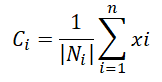

The model hyperparameters for a k-means clustering model are (discussed in more detail throughout the notebook):
- the number of cluster, k
- centroid initialisation method
- number of times k-means algorithm run with different centroid seeds
- maximum number of iterations of the k-means algorithm for a single run

The code below runs through the full pipeline of the model; from data exploration and visualisation, cleaning and manipulation, model development and model evaluation and analysis - refer to relevant sections

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import warnings 
warnings. filterwarnings('ignore')

## Data Exploration

Below displays the first 5 rows within the dataset. 

In [2]:
df = pd.read_csv(r"CC GENERAL.csv")
print(df.head())
print('\n')
print('Length of the dataset is: ', len(df), 'entries')

  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000       

The dataset is described below using .info() showing the datatype for each column, as well as the non-null count within each column. There are some null values in CREDIT_LIMIT and MINIMUM_PAYMENTS columns. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

The total count of null values in each column is shown below. 

In [4]:
print(df.isnull().sum())

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64


## Data Pre-Processing

This section describes how the data has been cleaned and pre-processed ready for model development.

Since the Customer ID is a unique identifier for each data entry row, the column was removed as it is unlikely to have any relationship to the determined clusters.

For the CREDIT_LIMIT column, there is one null value. Since a credit limit rating is very much dependent on an individual’s background, computing the mean, median or other statistical measurement would not be accurate so the single data entry row was removed. Removing a single data entry will not impact the k-means clustering process hugely. 

For minimum payments, 313 data entries is more significant, hence the median of the column was computed to fill these values. For a normally distributed dataset, using the mean would be representative. However when looking at a sample dataset, the median might be much more representative for the sample.

The dataset is then checked again for any more null values. 

In [5]:
#Clean data
df.drop(columns="CUST_ID", inplace=True)
df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median())
df.dropna(subset = ['CREDIT_LIMIT'], inplace = True)

In [6]:
#Confirm no more null values
print("Total number of nulls in dataset: ")
print(df.isnull().sum())

Total number of nulls in dataset: 
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64


## Further Data Exploratory and Visualisation

Using a correlation heat map across all columns within the dataset, general dependency trends can be spotted between columns.

<AxesSubplot: >

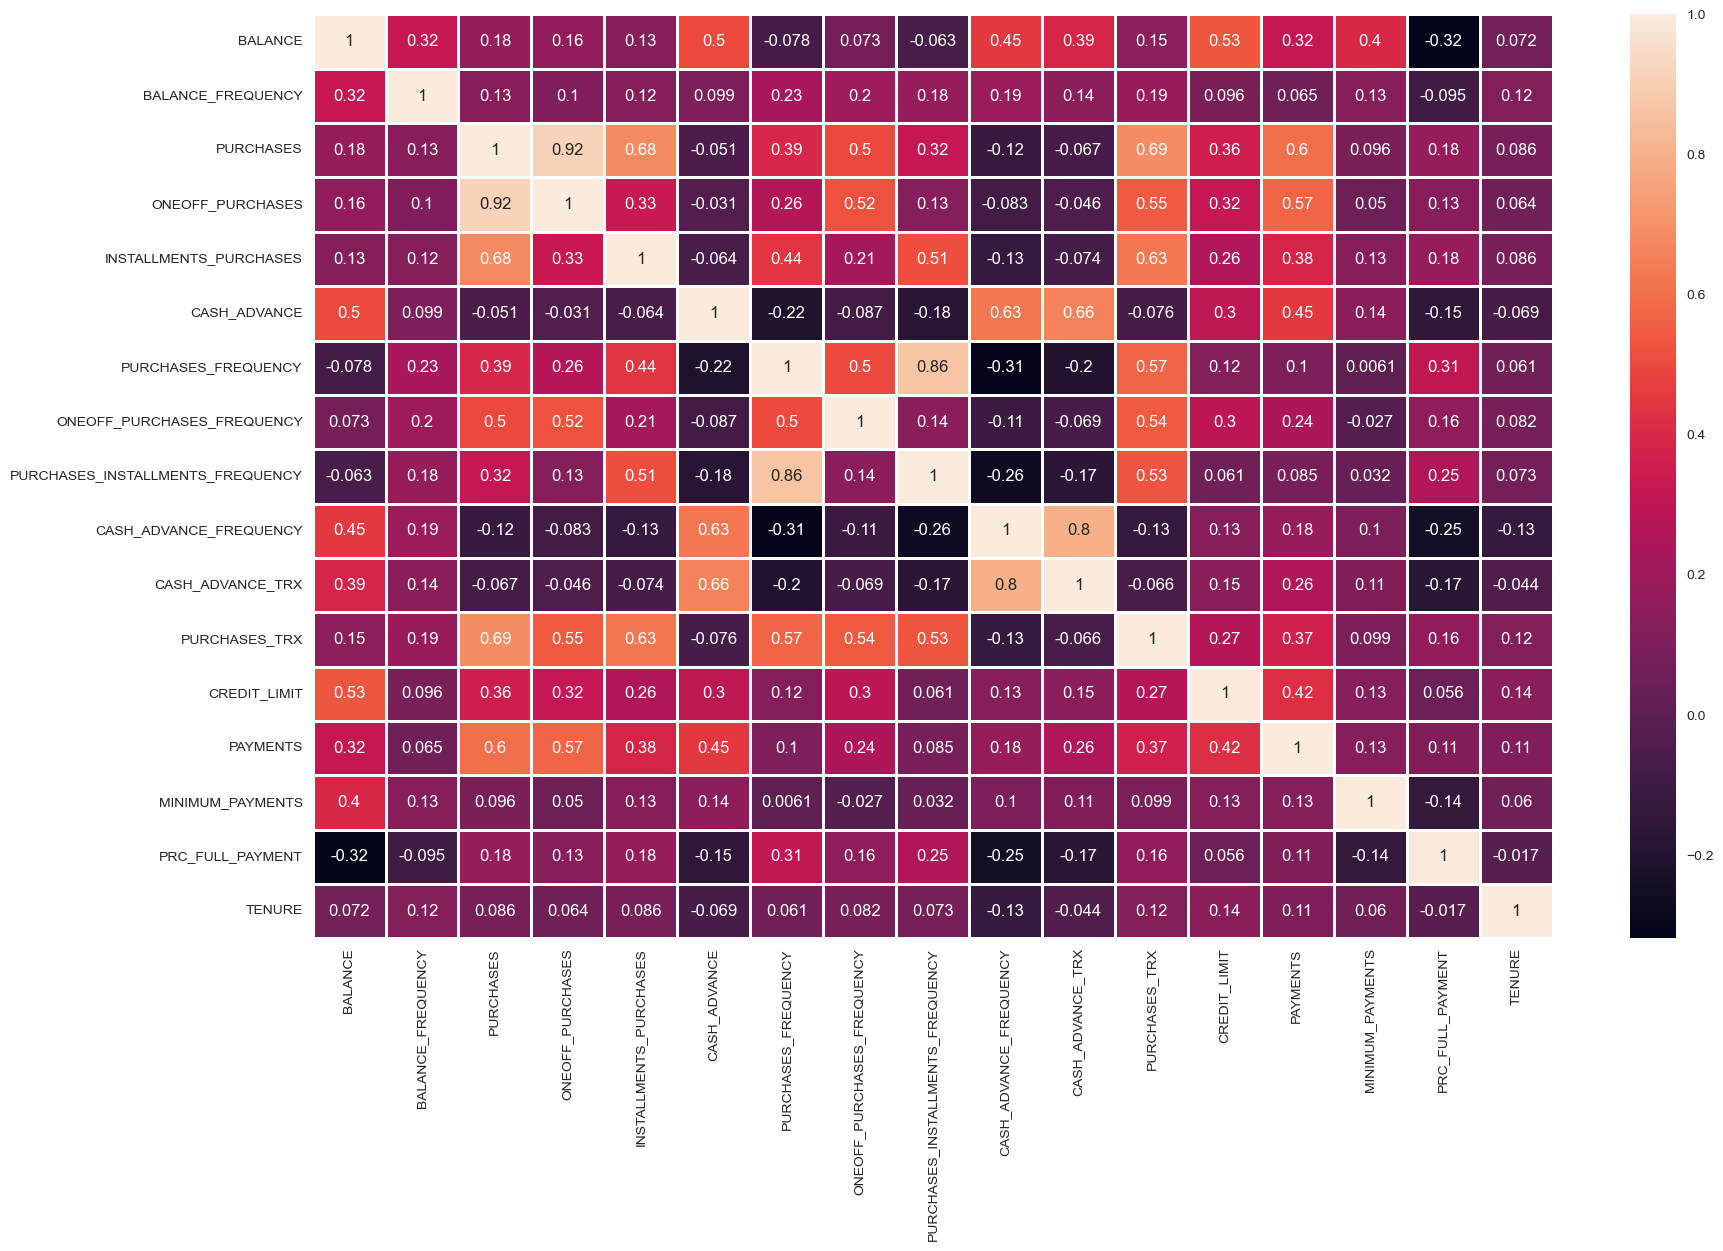

In [7]:
fig,ax=plt.subplots(1,1,figsize=(20,12))
sns.heatmap(df.corr(),annot=True,linewidths=1)

The following columns of the dataframe were selected for the k-means clustering model as they were deemed to be important factors of the clustering process based on the correlation heatmap as well as through discussion with relevant high level stakeholders: 
-	Balance 
-	Purchases 
-	Cash advance 
-	Credit limit
-	Payments
-	Minimum payments

This is new dataframe (data_df) is created below, with a sample shown. 

In [8]:
data_df = df[['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']]
data_df.head()

BALANCE  PURCHASES  CASH_ADVANCE  CREDIT_LIMIT     PAYMENTS  \
0    40.900749      95.40      0.000000        1000.0   201.802084   
1  3202.467416       0.00   6442.945483        7000.0  4103.032597   
2  2495.148862     773.17      0.000000        7500.0   622.066742   
3  1666.670542    1499.00    205.788017        7500.0     0.000000   
4   817.714335      16.00      0.000000        1200.0   678.334763   

   MINIMUM_PAYMENTS  
0        139.509787  
1       1072.340217  
2        627.284787  
3        312.343947  
4        244.791237

A pairplot between all columns to be analysed for the k-means clustering model is shown below as well as a correlation heatmap to visualise trends between columns. 

For example, generally the higher the number of purchases made from the account, the higher the amount of payment done by user as you'd expect. 

The higher the credit limit of the account, the larger the balance is on the account.

The higher the payment is on the account, the lower the cash advance.

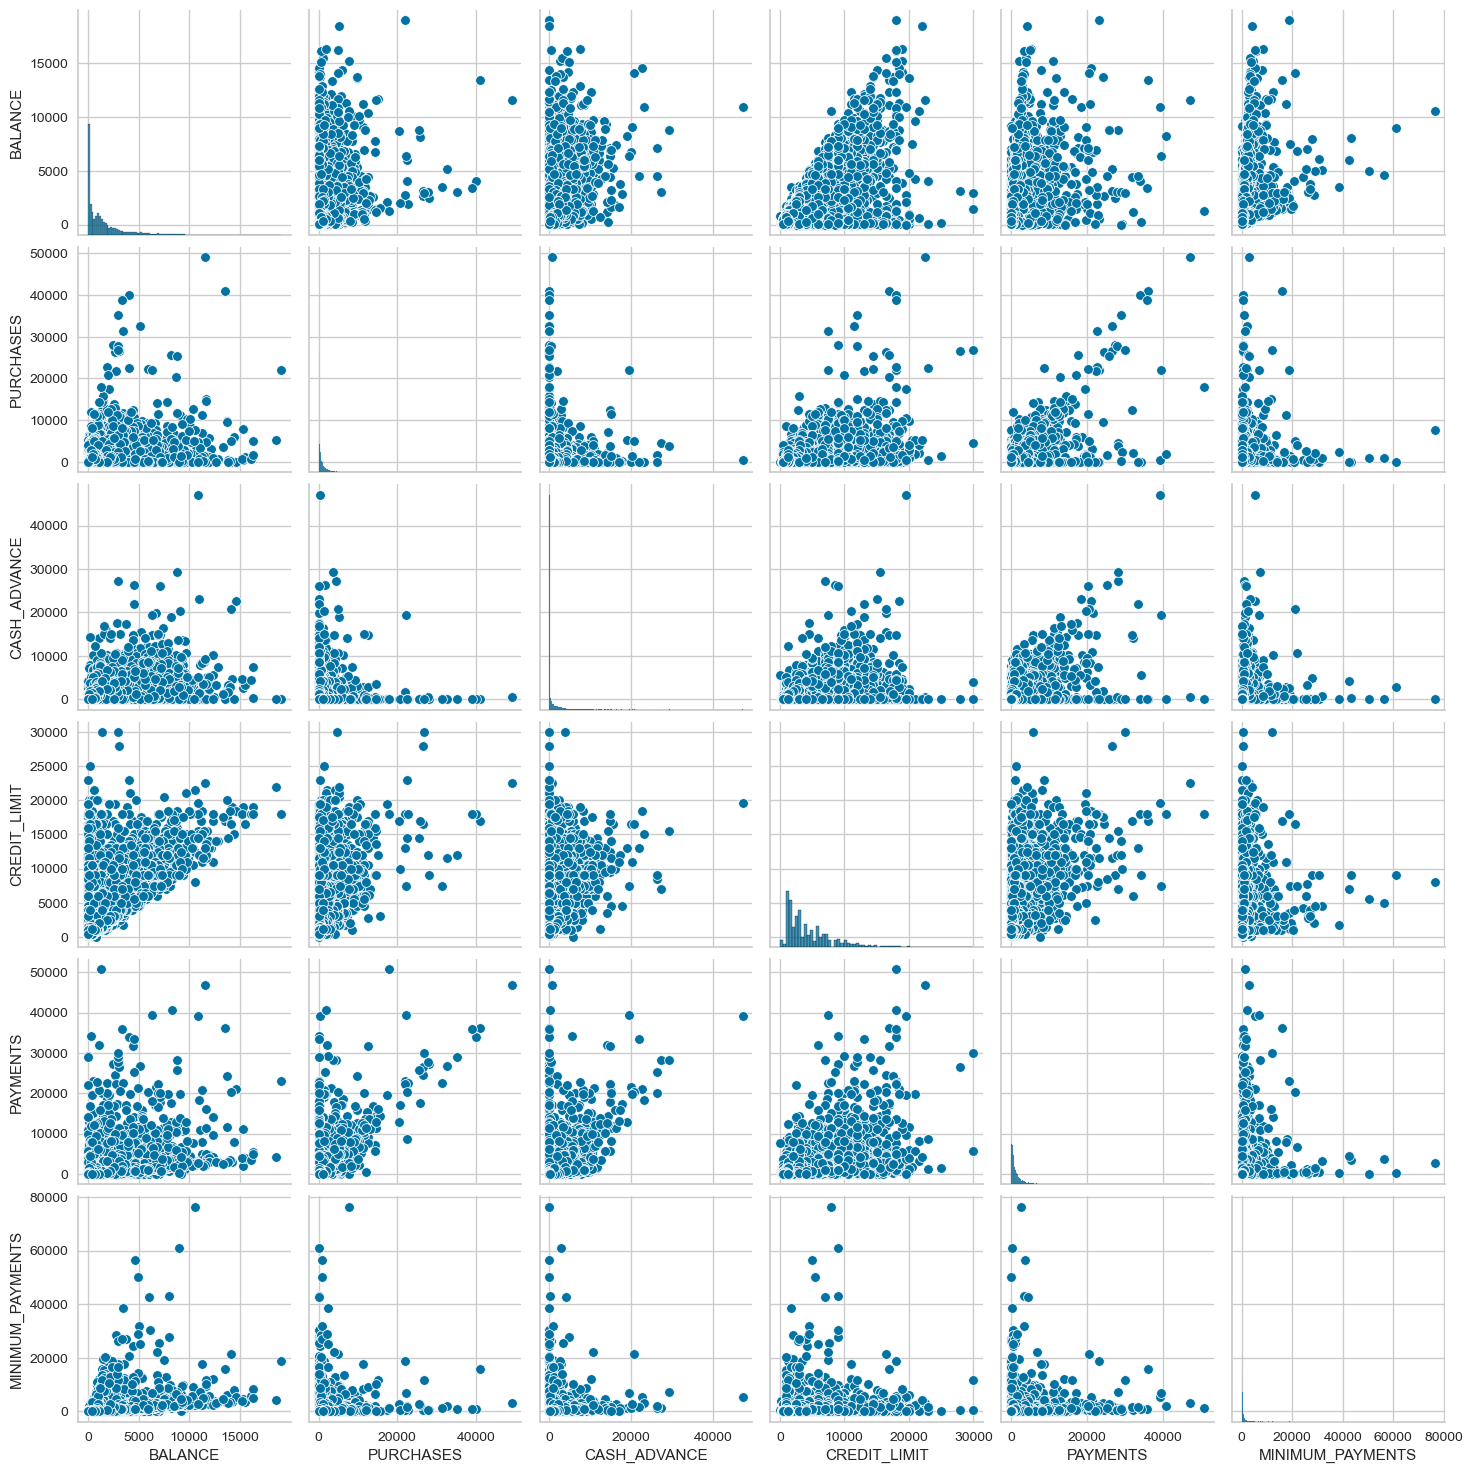

In [9]:
sns.pairplot(data_df)

<AxesSubplot: >

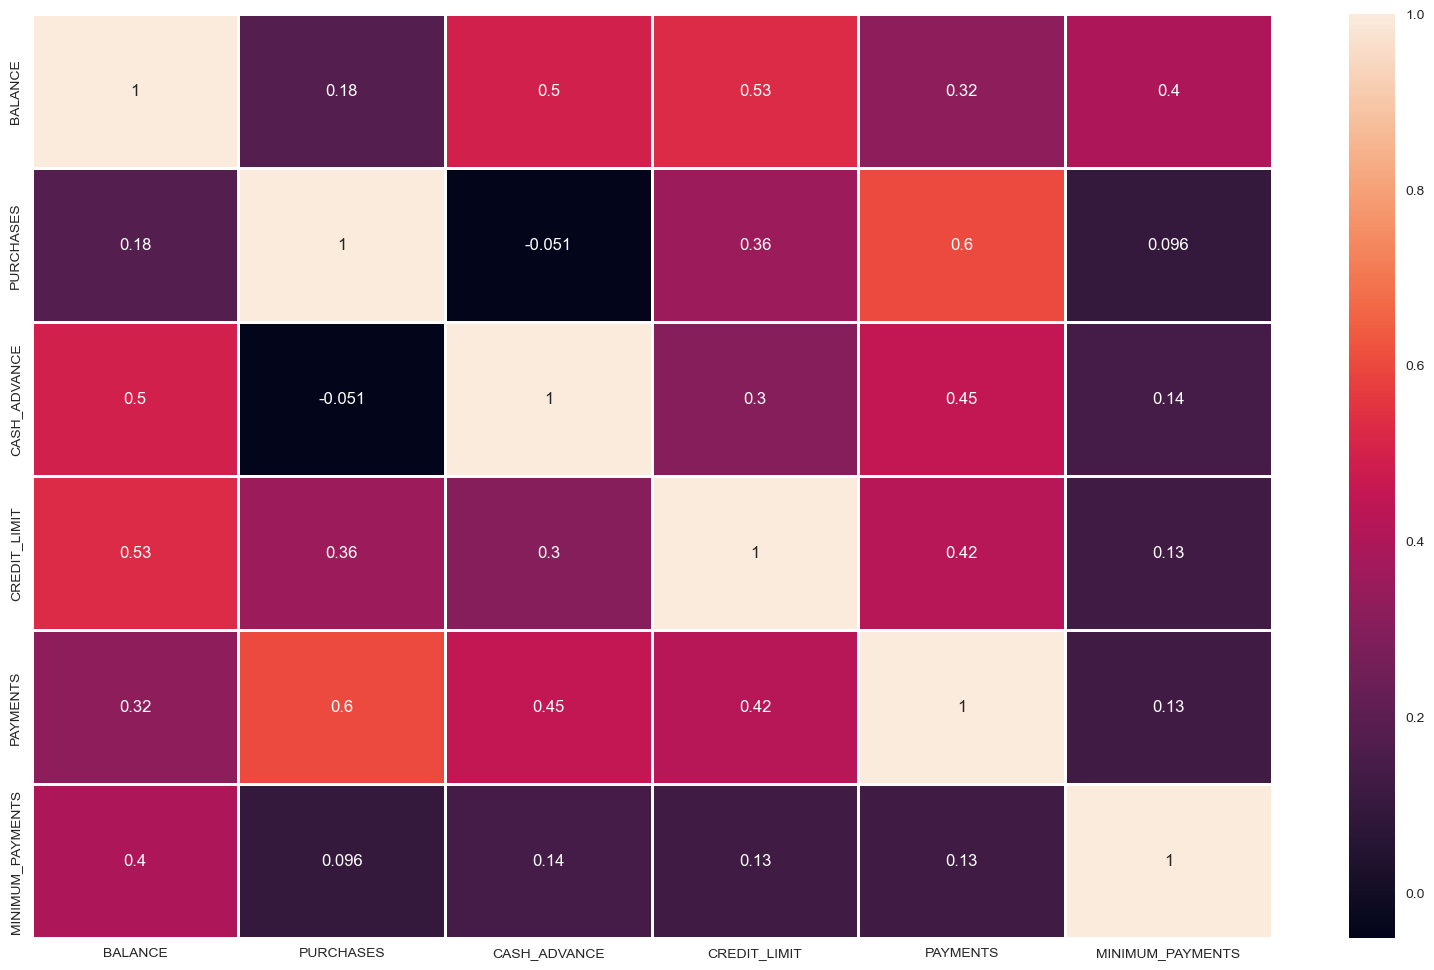

In [10]:
fig,ax=plt.subplots(1,1,figsize=(20,12))
sns.heatmap(data_df.corr(),annot=True,linewidths=1)

Since k-means clustering uses distance-based measurements to determine the similarity between data points, the data is standardised to have a mean of 0 and a standard deviation of 1. The first 5 rows of the scaled dataframe is shown below. 

In [11]:
#Standardise data as ranges of numbers are varied across dataset
scaler = StandardScaler()
df_scaled = scaler.fit_transform(data_df)
df_scaled[0:5]

array([[-0.73205404, -0.4249337 , -0.4668054 , -0.96037969, -0.52902627,
        -0.30242503],
       [ 0.78685815, -0.4695839 ,  2.6054375 ,  0.68860056,  0.81854607,
         0.09745499],
       [ 0.44704093, -0.10771601, -0.4668054 ,  0.82601558, -0.38385745,
        -0.09332864],
       [ 0.04901491,  0.23199527, -0.3686778 ,  0.82601558, -0.59873323,
        -0.22833554],
       [-0.35884931, -0.4620954 , -0.4668054 , -0.90541368, -0.36442122,
        -0.25729362]])

## Model Development

The following hyperparameters can be set for a k-means clustering model:

- <b>Initialisation method <i>("init")</b></i>: k-means clustering starts by initialising centroid locations for any given k. There are a few different initialiation methods for the cluster locations defined by hyperparameter init in sklearn. "random" assigns k-clusters rows of data at random for initial centroid locations. The one used in the code below is "k-means++" selects a random datapoint as the first centroid location, and then places next subsequent centroid locations at a distance based on probability proportional to the squared distance away from given point's nearest existing centroid. The idea is to maximise the distance between centroid locations from the beginning in order to reduce iterations for convergence. 
<br>

- <b>Maximum number of iterations <i>("max_iter")</b></i>: this sets an upper limit on the number of times the algorithm will iterative, to prevent infinite loops in case the solution does not converge. This is left as the default value of 300. 
<br>

- <b>Number of times k-means is run with different centroid seeds <i>("n_init")</b></i>: the k-means model is run multiple times with different initial centroid seeds. The solution with the lowest inertia (i.e. sum of squared distances from each point to its assigned centroid) will be selected. This subsequently reduces the risk of getting stuck in local minimas and increase chances of finding an optimal solution. This was set to 10 (default value).
<br>

- <b>Number of clusters <i>("k")</b></i>: this is the most important hyperparameter in the k-means clustering model as this determines the number of clusters. There are a couple methods of finding the optimal k discussed below. 
<br>

### Elbow Method for Optimal k

The elbow method is one method of finding the optimal cluster value. For every k value, the within-cluster sum of squares (WCCS) is given by the sum of square distance between points in a cluster and centroid – as shown in the equation below. It is thought the optimal k is found where the WCCS value starts converging.
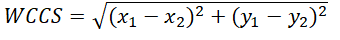

Initially, the k-elbow joint method was used as a way of estimating the optimal number of clusters. The code shows a graph of the resulting k-elbow plot. Using this method, k=7 looks optimal though is quite subjective since k=5 and k=10 also seem like good values.

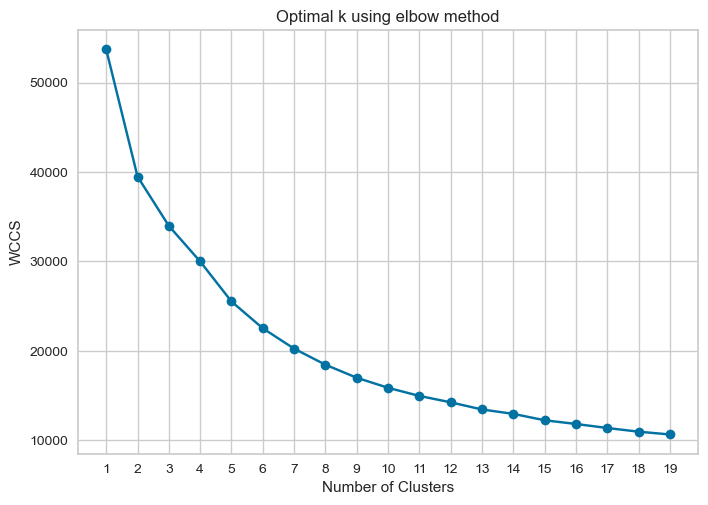

In [12]:
wccs = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10)
    kmeans.fit(df_scaled)
    wccs.append(kmeans.inertia_)

#visualise results for WCCS
plt.plot(range(1, 20), wccs, marker='o')
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("WCCS")
plt.title("Optimal k using elbow method")
plt.show()

### Silhouette score for optimal k

Another key metric to evaluating k-means clustering is the Silhouette score. The Silhouette score is a measure of how close each point is to neighbouring cluster centroids. A value of 0 indicates that the data point is close to a class boundary of two neighbouring clusters. Positive value indicates how far data points are from cluster boundaries and negative values indicates samples that could be assigned to incorrect cluster – it is desirable to have a high Silhouette score. 

The equation below is used to calculate the Silhouette Score for each point where a_i represents the average distance to all other data points in the same cluster (intra-cluster distance) and b_i represents the average distance to all points in the nearest cluster (inter-cluster distance). The overall Silhouette Score is calculated by averaging all individual Silhouette Scores for all data points.

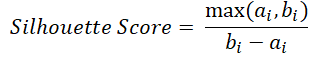

For this model, the Silhouette score for values of k=2-20 were analysed as shown in the graph below. This shows high Silhouette score for k=2, k=3 and k=4. When k=7, this has a lower Silhouette score which suggests that for lower number of clusters seems to segregate the data better.

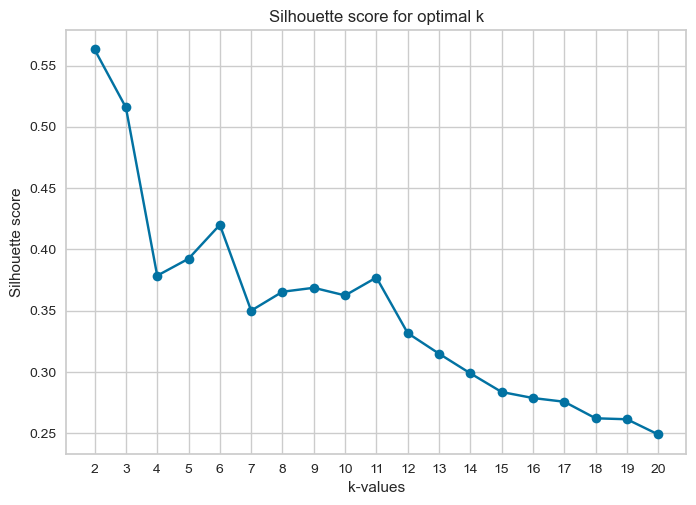

In [13]:
k = np.arange(2,21,1)
sil = []

for n in k:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(df_scaled)
    lbls = kmeans.labels_
    sil.append(silhouette_score(df_scaled, lbls, metric='euclidean'))
    
plt.plot(k, sil, marker='o')
plt.xticks(k)
plt.xlabel('k-values') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette score for optimal k')
plt.show()

### k=2 for clustering

A k=2 model was then computed and the output predicted classes were added to the data_df dataframe. A pairplot, shown below, of all column features were plotted using the predicted classes as the hue parameter. 

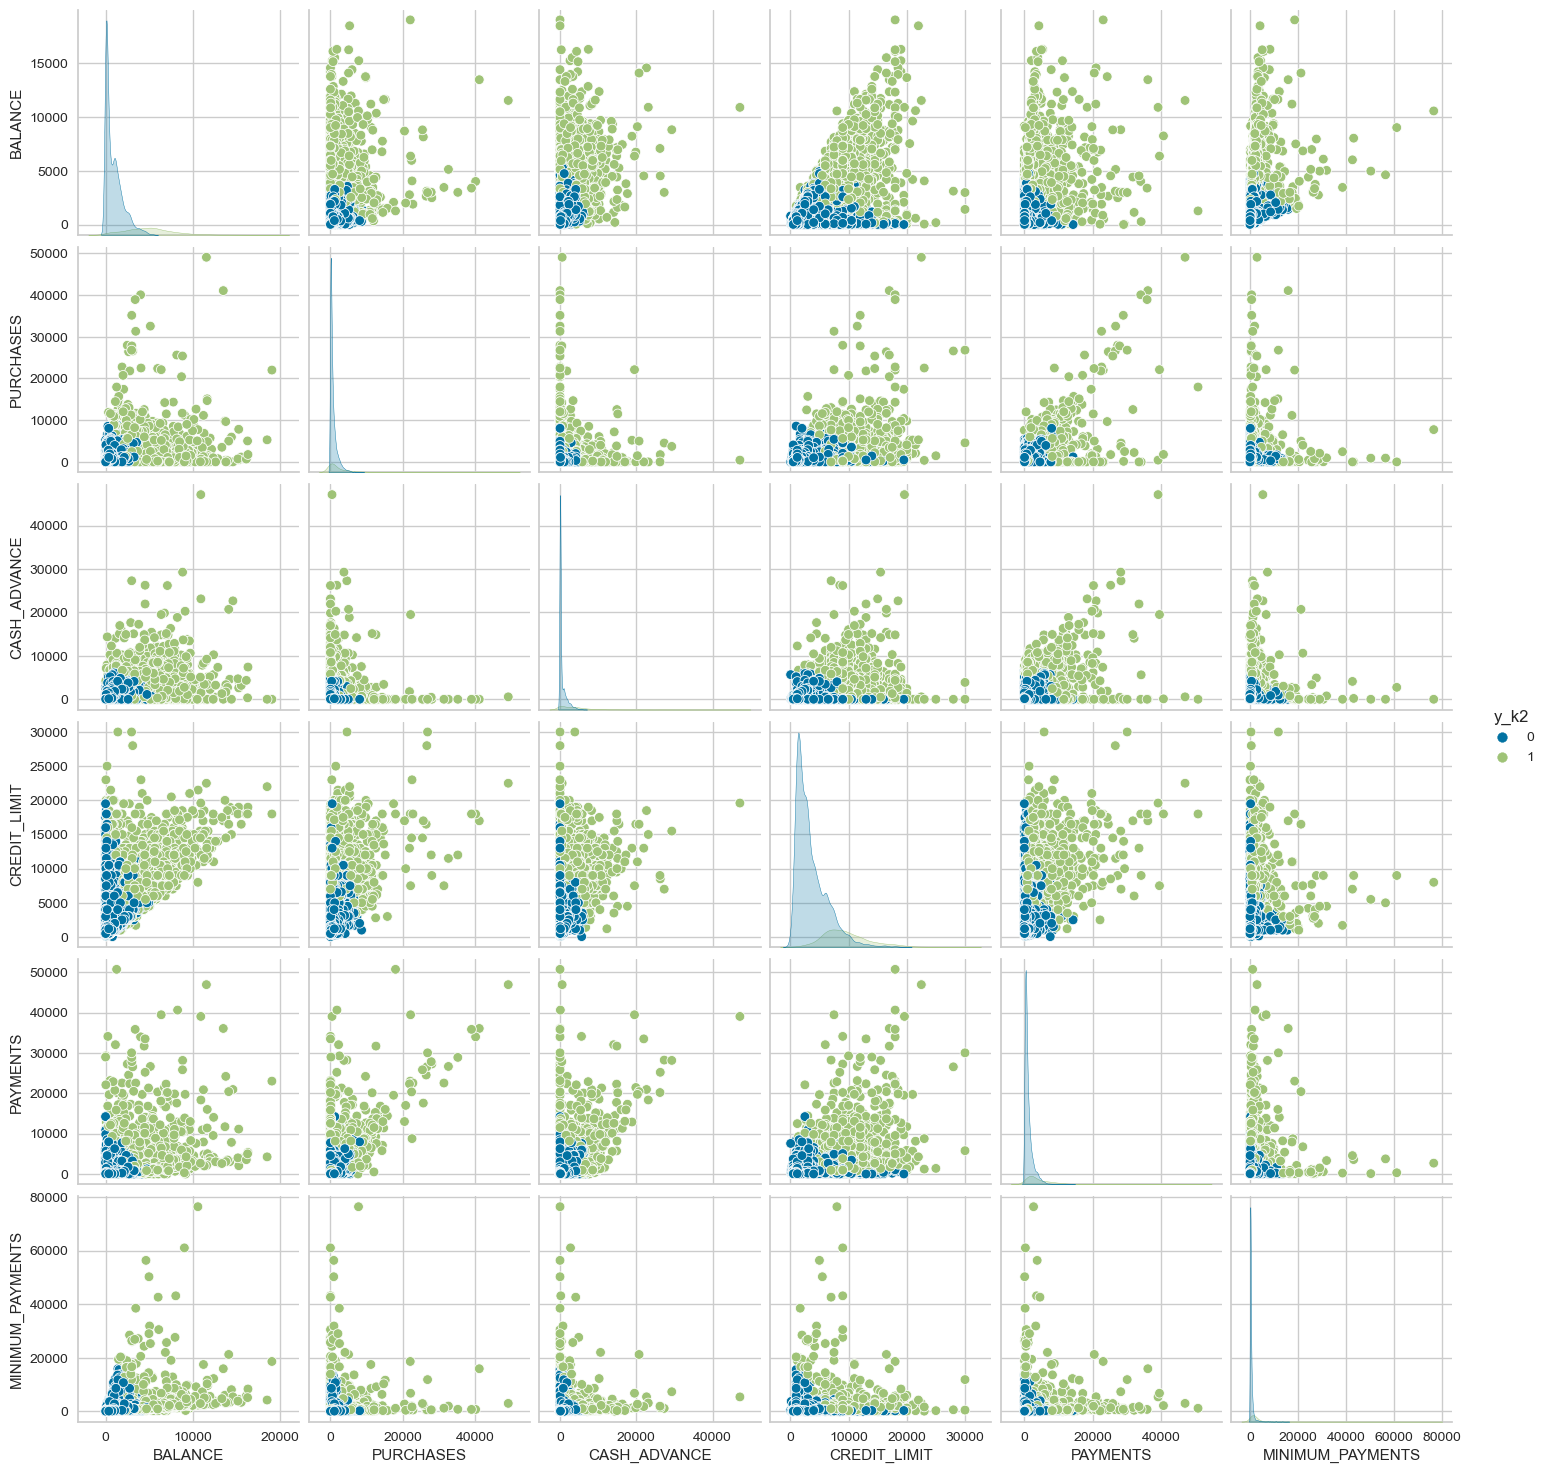

In [14]:
kmeans = KMeans(n_clusters=2, init="k-means++", n_init=10, max_iter=300)
y_pred = kmeans.fit_predict(df_scaled)
cols = list(data_df.columns)
data_df['y_k2'] = y_pred
sns.pairplot(data_df, hue='y_k2')

In [ ]:
##Has solution converged yet... 

Boxplots of each feature against predicted classes were plotted as shown below. From these plots, the following observations were made:
-	Cluster 0 had a lower balance relative to cluster 1 as shown by the difference in mean values.
-	Cluster 0 had a lower credit limit than cluster 1 as shown by the difference in mean values.
-	Cluster 1 were more likely to make more purchases as shown by the difference in range.
-	Cluster 1 were more likely to obtain large cash advances as shown by the higher mean value. 
-	Cluster 1 were more likely to make larger payments to pay off credit card debts than Cluster 0.
-	Cluster 1 were more likely to make larger minimum payments than Cluster 0.
-	Overall, the analysis suggests that cluster 0 is of a lower-income relative to cluster 1.


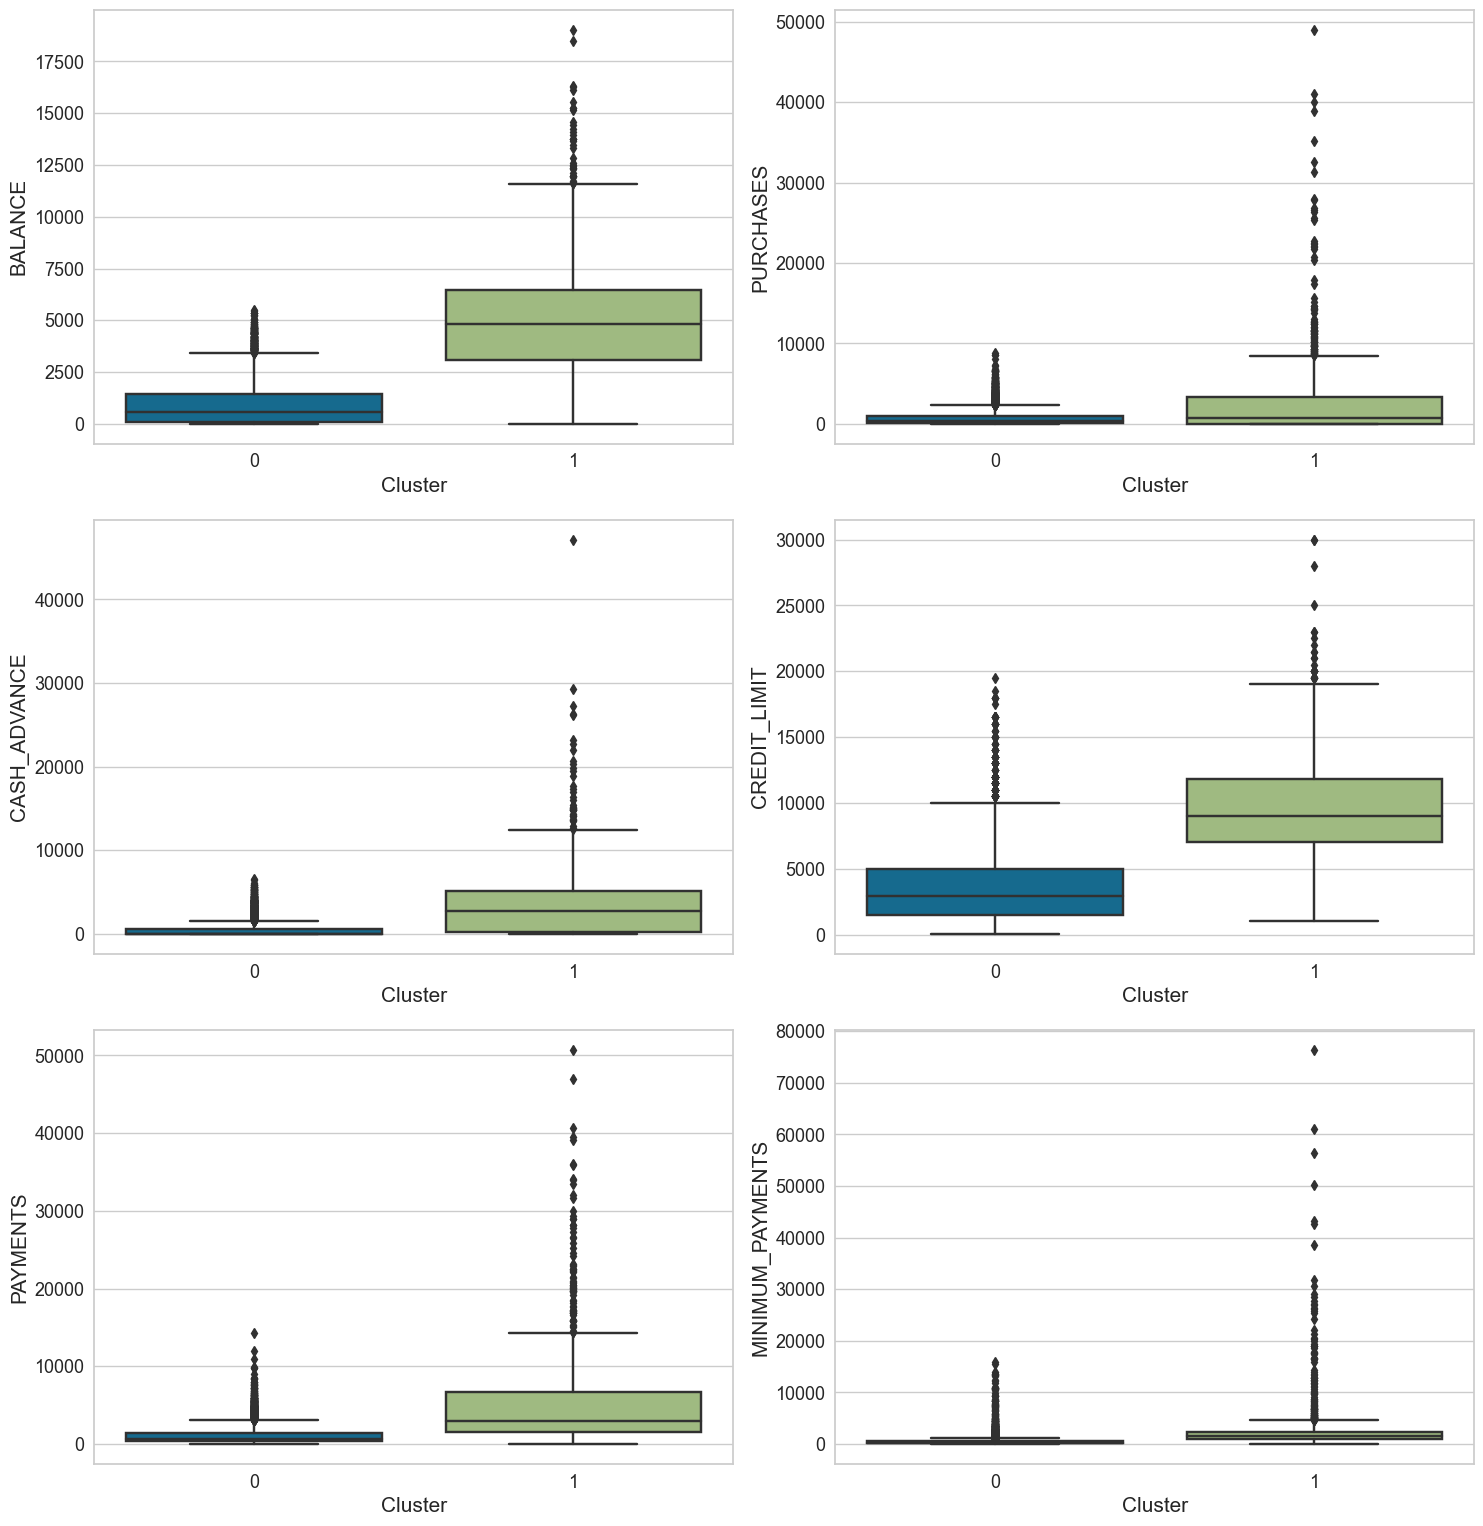

In [15]:
plt.figure(figsize = (15, 20))
for i, col in enumerate(cols):
    ax = plt.subplot(4, 2, i+1)
    sns.boxplot(x = data_df['y_k2'], y = df[col])
    plt.xlabel("Cluster", fontsize = 15)
    plt.ylabel(col, fontsize = 15)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
plt.tight_layout()
plt.show()

Solutions for k=3 and k=4 are shown below with the respective pairplots and boxplots. Have a look to see what conclusions on the determined clusters could be drawn from those graphs. 

Having to analyse the model outputs in terms of its clusters and how the model has interpreted its clusters can be a challenging and time-consuming. This can subsequently be a drawback in developing an unsupervised learning model. 

### k=3 for clustering

       BALANCE  PURCHASES  CASH_ADVANCE  CREDIT_LIMIT     PAYMENTS  \
0    40.900749      95.40      0.000000        1000.0   201.802084   
1  3202.467416       0.00   6442.945483        7000.0  4103.032597   
2  2495.148862     773.17      0.000000        7500.0   622.066742   
3  1666.670542    1499.00    205.788017        7500.0     0.000000   
4   817.714335      16.00      0.000000        1200.0   678.334763   

   MINIMUM_PAYMENTS  y_k2  y_k3  
0        139.509787     0     1  
1       1072.340217     1     2  
2        627.284787     0     1  
3        312.343947     0     1  
4        244.791237     0     1  


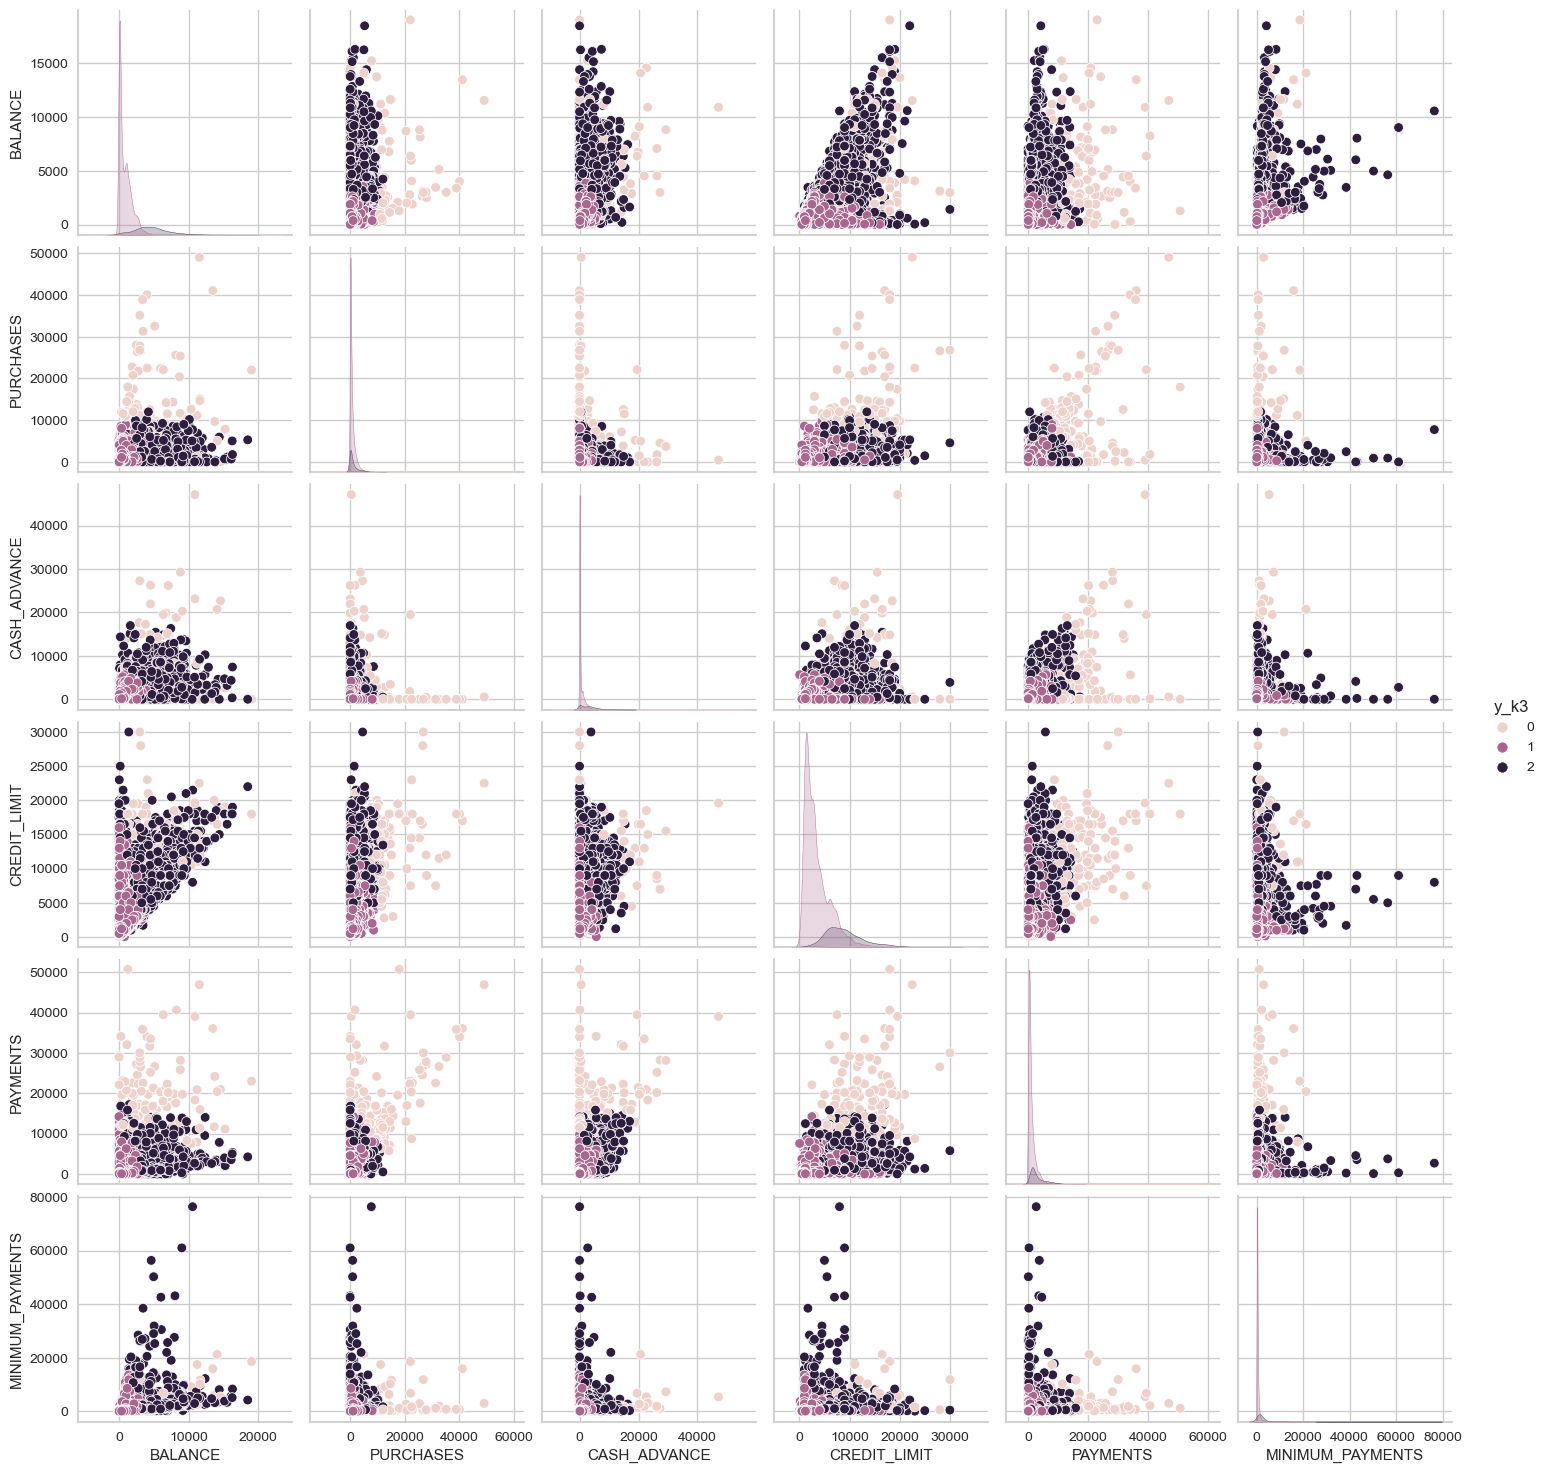

In [16]:
kmeans = KMeans(n_clusters=3, init="k-means++", n_init=10, max_iter=300)
y_pred = kmeans.fit_predict(df_scaled)
data_df['y_k3'] = y_pred
print(data_df.head())
sns.pairplot(data_df.drop('y_k2', axis=1), hue='y_k3')

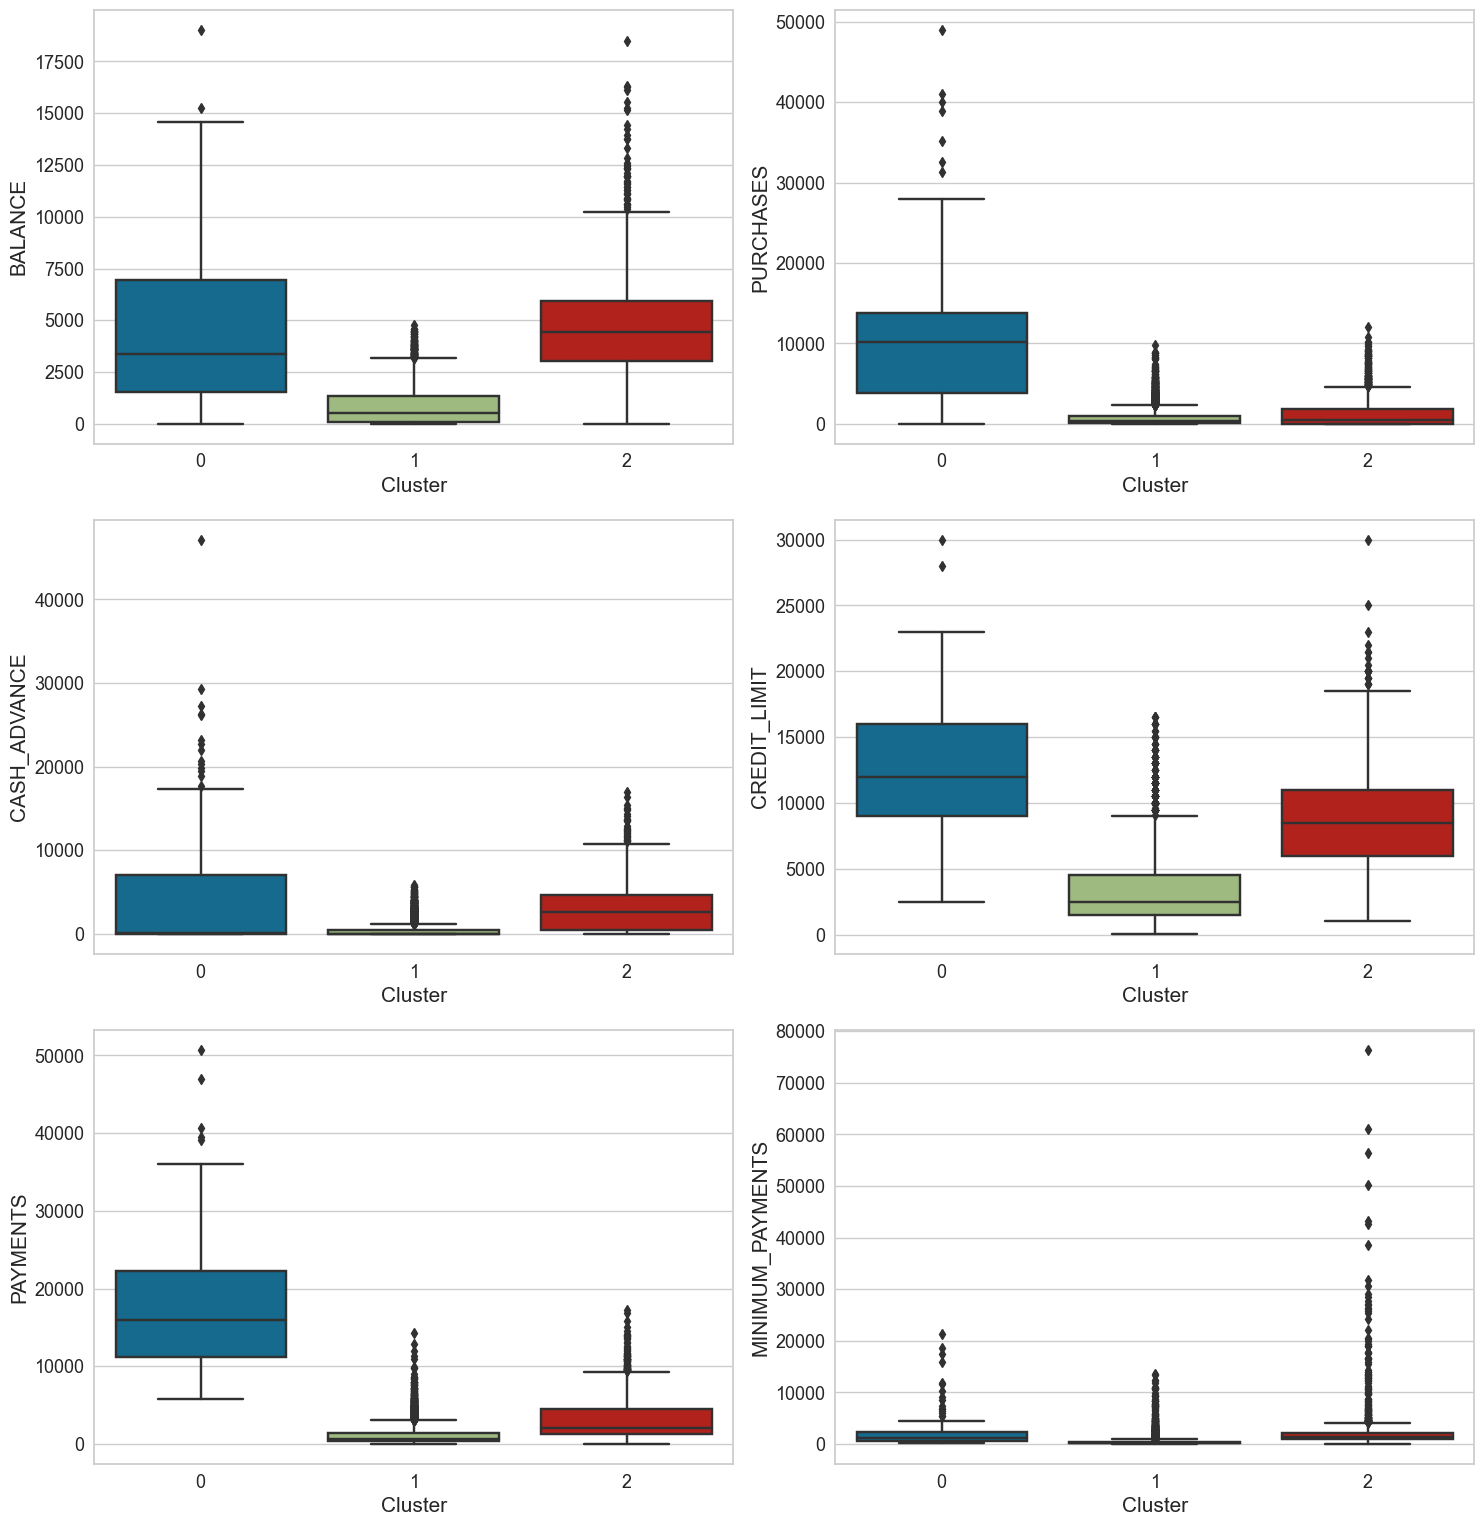

In [17]:
plt.figure(figsize = (15, 20))
for i, col in enumerate(cols):
    ax = plt.subplot(4, 2, i+1)
    sns.boxplot(x = data_df['y_k3'], y = df[col])
    plt.xlabel("Cluster", fontsize = 15)
    plt.ylabel(col, fontsize = 15)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
plt.tight_layout()
plt.show()

### k=4 for clustering

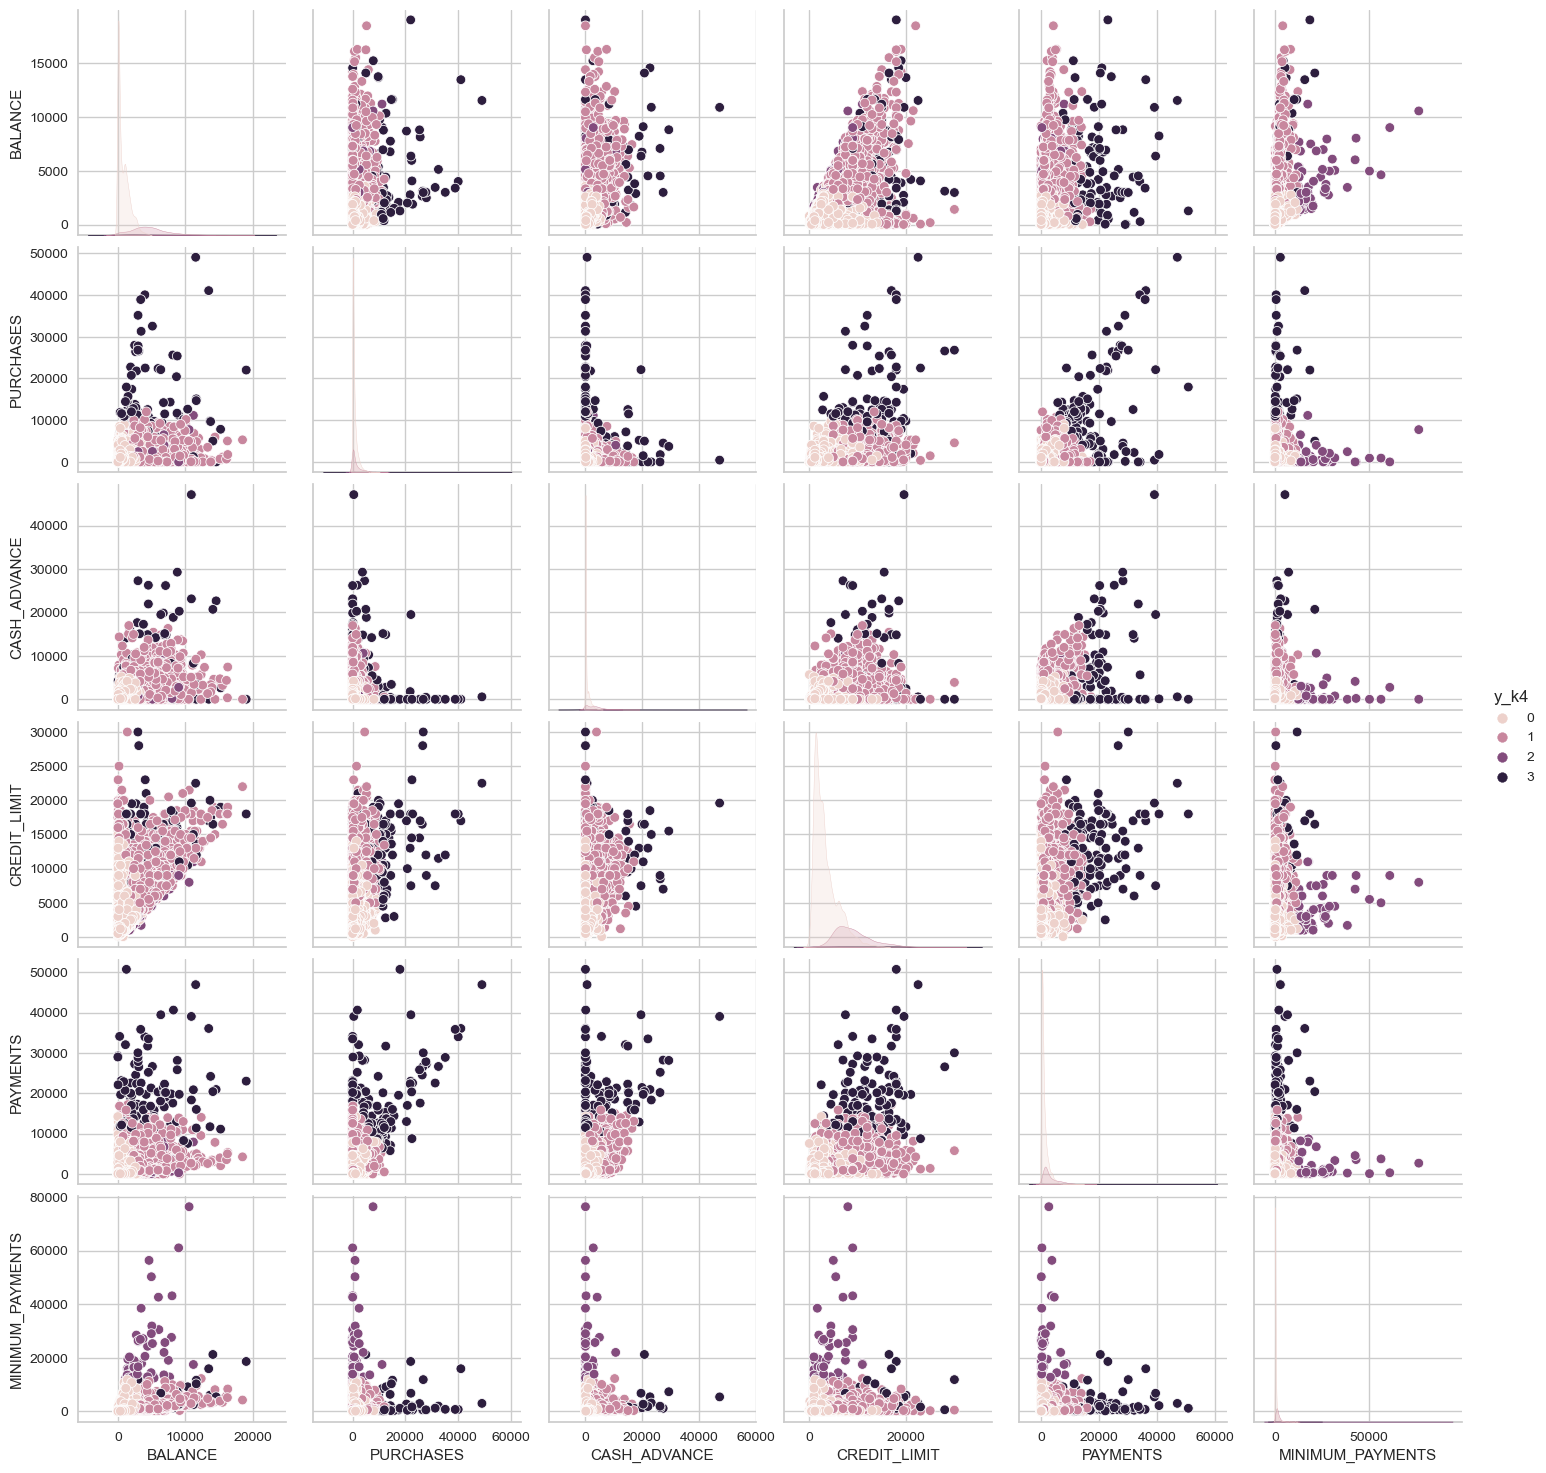

In [18]:
kmeans = KMeans(n_clusters=4, init="k-means++", n_init=10, max_iter=300)
y_pred = kmeans.fit_predict(df_scaled)
data_df['y_k4'] = y_pred
sns.pairplot(data_df.drop(['y_k2', 'y_k3'], axis=1), hue='y_k4')

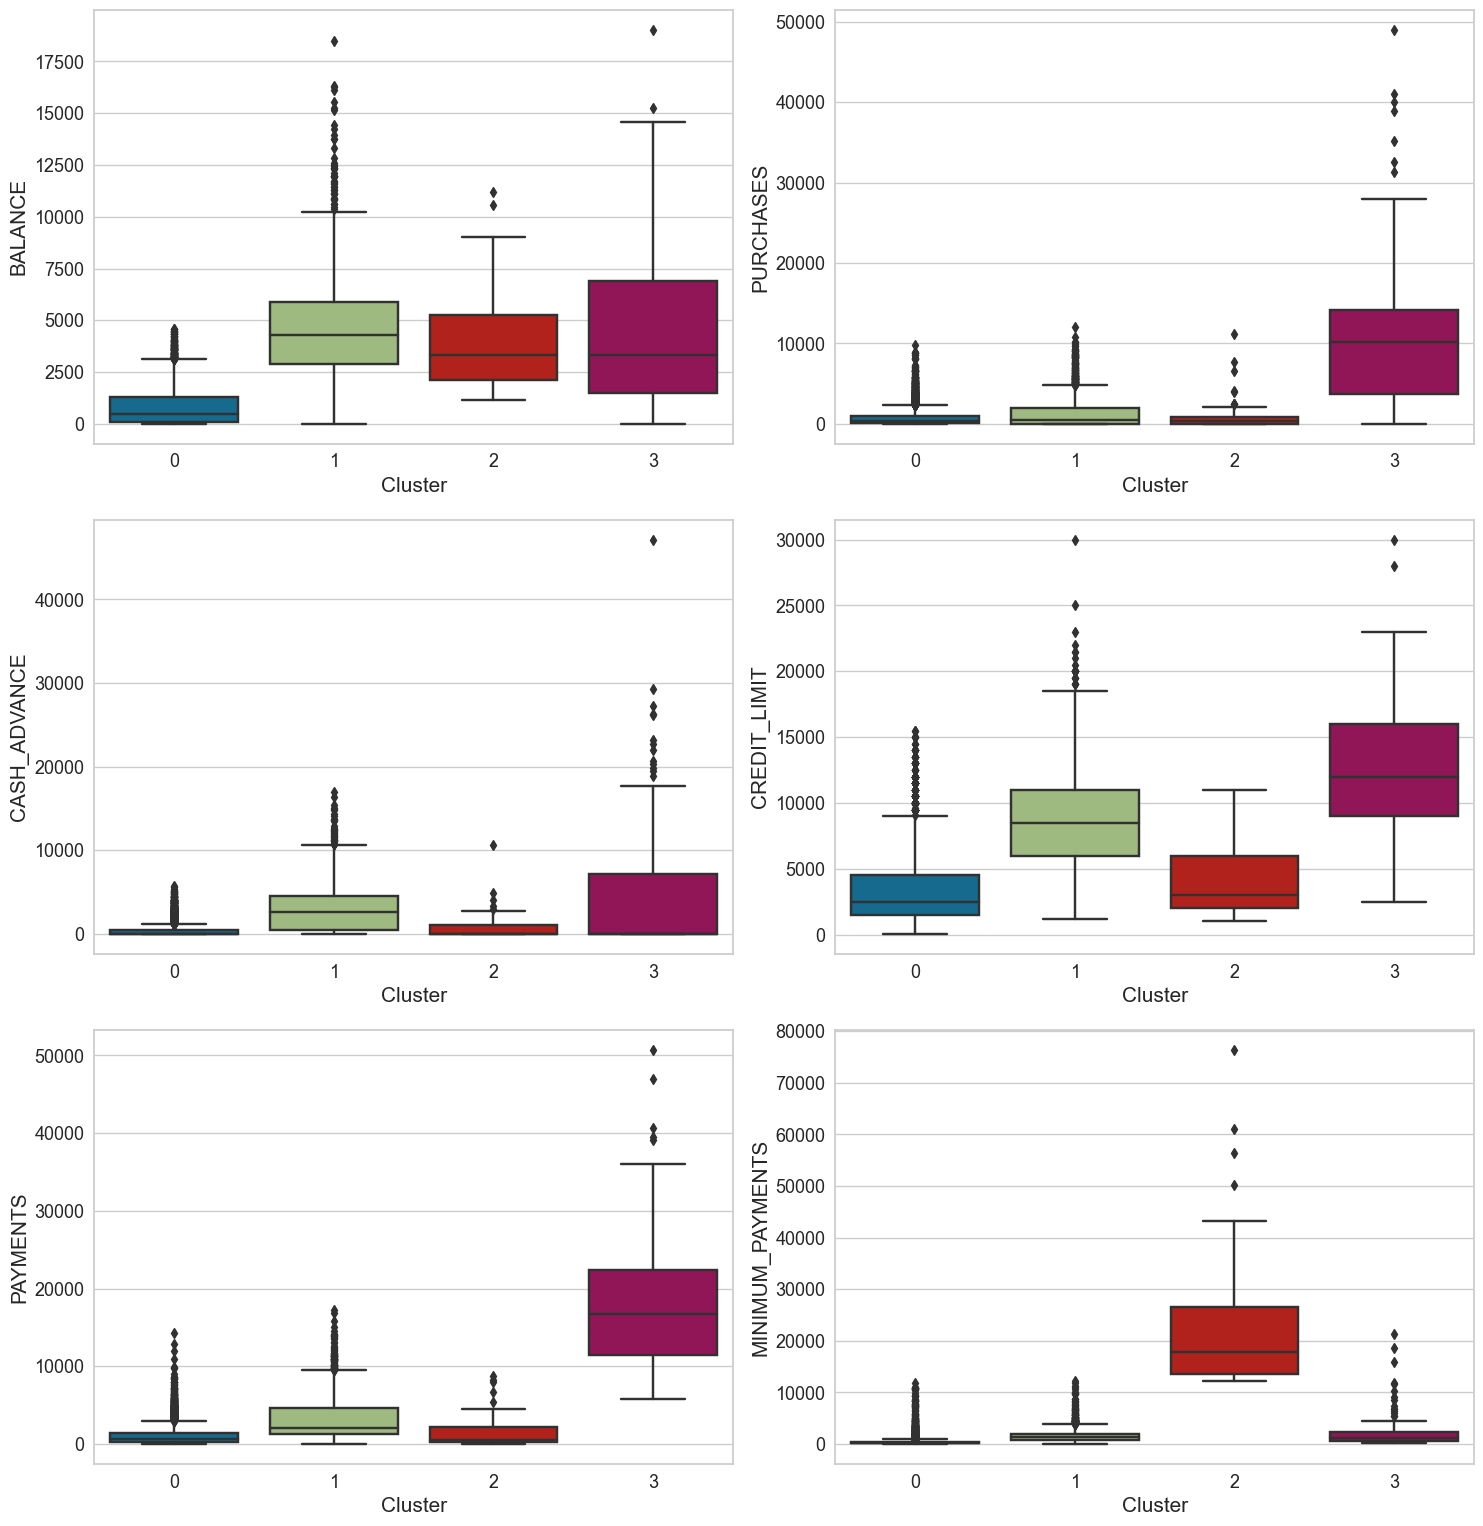

In [19]:
plt.figure(figsize = (15, 20))
for i, col in enumerate(cols):
    ax = plt.subplot(4, 2, i+1)
    sns.boxplot(x = data_df['y_k4'], y = df[col])
    plt.xlabel("Cluster", fontsize = 15)
    plt.ylabel(col, fontsize = 15)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
plt.tight_layout()
plt.show()